<a href="https://colab.research.google.com/github/madhavamk/computational-data-science/blob/master/MiniProjects/M6_NB_MiniProject_2_Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Face Mask Detection using Convolutional Neural Networks

## Learning Objectives

At the end of the miniproject, you will be able to :

* load and extract features of images using ImageDataGenerator

* build the convolutional neural networks

* use the pre-trained models using keras applications

## Introduction

This project uses a Deep Neural Network, more specifically a Convolutional Neural Network, to differentiate between images of people, with masks, without masks and incorrectly placed masks. Manually built and pretrained networks will be used to perform this classification task.

**Face-Mask-Detection-Using-CNN**

* Outbreak of the Coronavirus pandemic has created various changes in the lifestyle of everyone around the world.
* Among these changes, wearing a mask has been very vital to every individual.
* Detection of people who are not wearing masks is a challenge due to the large populations.
* This face mask detection project can be used in schools, hospitals, banks, airports etc as a digitalized scanning tool.
  - The technique of detecting people’s faces and segregating them into three classes namely the people with masks and people without masks and partial masks is done with the help of image processing and deep learning.
* With the help of this project, a person who is monitoring the face mask status for a particular firm can be seated in a remote area and still monitor efficiently and give instructions accordingly.

![img](https://cdn.iisc.talentsprint.com/CDS/MiniProjects/dataset-images-with-mask.jpg)

## Dataset

The data for this mini-project is collected from various sources including the masked images from internet and general frontal face images considered as without mask. This dataset consists of 5029 train images and 1259 test images with 3 classes `with_mask`, `without_mask` and `partial_mask`

Many people do not correctly wear their masks due to bad practices, bad behaviors or vulnerability of individuals (e.g., children, old people). For these reasons, several mask wearing campaigns intend to sensitize people about this problem and good practices. In this sense, this work proposes three types of masked face detection dataset:

- Without Mask/ With Mask/ Partial Mask

Note that this dataset contains some annotated (artificially generated) masks to augment the 'masked' data category.

## Problem Statement

To build and implement a Convolutional Neural Network model to classify between masked/unmasked/partially masked faces.

## Grading = 10 Points

In [1]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/MP2_FaceMask_Dataset.zip
!unzip -qq MP2_FaceMask_Dataset.zip
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


### Import Required packages

In [2]:
from tensorflow.keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import PIL
from matplotlib import pyplot as plt
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow import keras
import glob, os

## Data Loading and preprocessing (2 points)

### Analyze the shape of images and distribution of classes

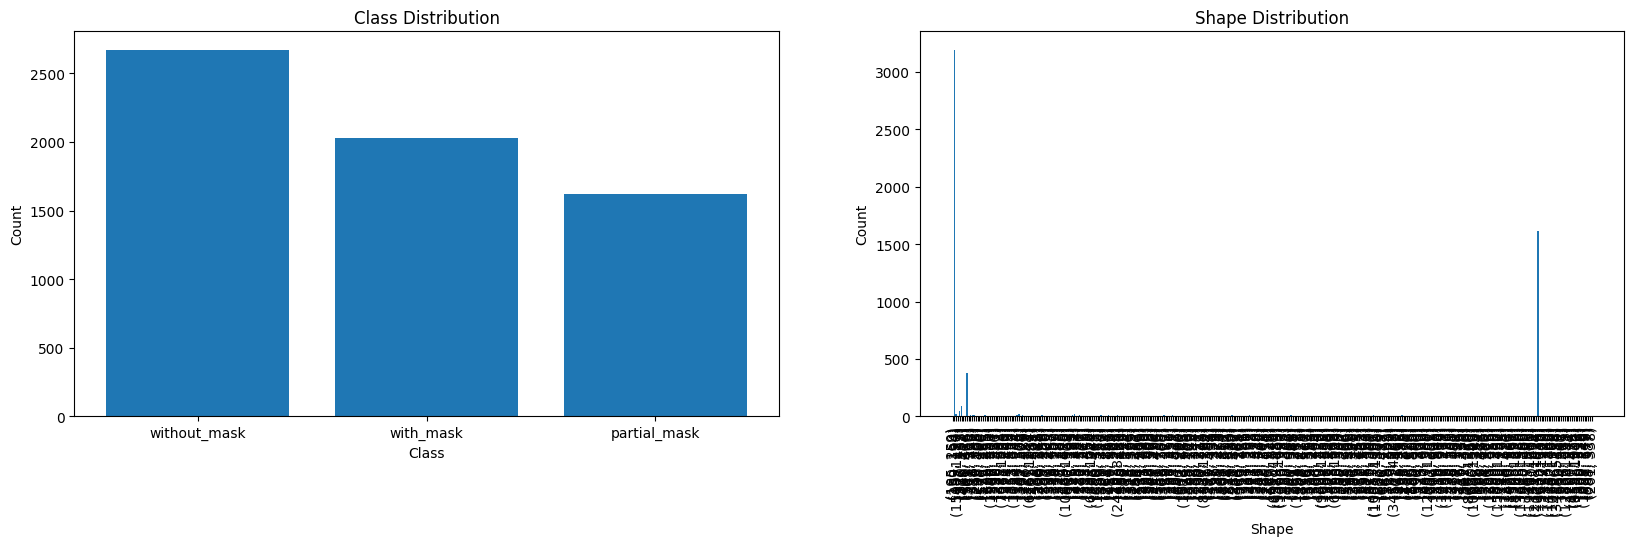

In [3]:
# YOUR CODE HERE
from PIL import Image

def load_data_analyze_shape():
    shapes = {}
    class_distribution = {}
    for path in glob.iglob('/content/MP2_FaceMask_Dataset/**', recursive=True):
        if not os.path.isfile(path):
            continue
        if path.split('/')[4] in class_distribution:
            class_distribution[path.split('/')[4]] += 1
        else:
            class_distribution[path.split('/')[4]] = 1
        img = Image.open(path)
        if str(img.size) in shapes:
            shapes[str(img.size)] += 1
        else:
            shapes[str(img.size)] = 1

    return shapes, class_distribution

shapes, class_distribution = load_data_analyze_shape()

def plot_data_distribution(shapes, class_distribution):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.bar(class_distribution.keys(), class_distribution.values())
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')

    plt.subplot(1, 2, 2)
    plt.bar(shapes.keys(), shapes.values())
    plt.xlabel('Shape')
    plt.ylabel('Count')
    plt.title('Shape Distribution')
    # Rotate the graph
    plt.xticks(rotation=90)
    plt.show()

plot_data_distribution(shapes, class_distribution)

**Analysis**


*   Distribution of images in different classes show similar distribution
*   Distribution of shapes of images has outliers with few shapes outnumbering others.



In [4]:
# Get top 5 shapes from shapes dictionary
top_5_shapes = dict(sorted(shapes.items(), key=lambda x: x[1], reverse=True)[:5])
print(top_5_shapes)

{'(160, 160)': 3193, '(1024, 1024)': 1617, '(320, 428)': 381, '(320, 433)': 89, '(327, 433)': 45}


### Load the images using ImageDataGenerator

There are two main steps involved in creating the generator.
1. Instantiate ImageDataGenerator with required arguments to create an object
2. Use the `flow_from_directory` command depending on how your data is stored on disk. This is the command that will allow you to generate and get access to batches of data on the fly.

Hint: [link](https://keras.io/api/preprocessing/image/)

In [5]:
TRAINING_DIR = "/content/MP2_FaceMask_Dataset/train/"
VALIDATION_DIR = "/content/MP2_FaceMask_Dataset/test/"

In [6]:
# YOUR CODE HERE
# As per the tensorflow documentation, preprocessing library is deprecated
image_generator = ImageDataGenerator(rescale=1./255,
                                     horizontal_flip=True,
                                     zoom_range=0.2)
train_generator = image_generator.flow_from_directory(TRAINING_DIR,
                                                      batch_size=10,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))
validation_generator = image_generator.flow_from_directory(VALIDATION_DIR,
                                                          batch_size=10,
                                                          class_mode='categorical',
                                                          target_size=(224, 224))

Found 5029 images belonging to 3 classes.
Found 1259 images belonging to 3 classes.


### Visualize the sample images of each class using data generator

Hint: plt.subplot

In [7]:
batch = next(train_generator)
print(batch[1])

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


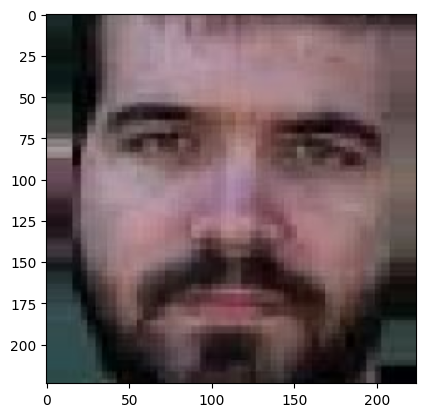

In [8]:
plt.imshow(batch[0][5])

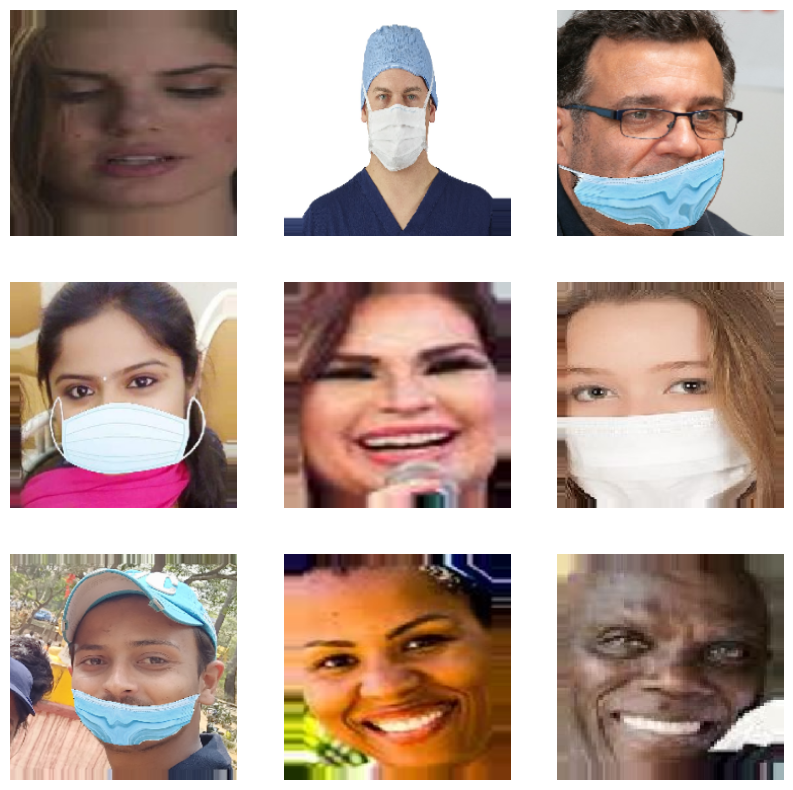

In [9]:
# YOUR CODE HERE
# The generator will yield a tuple (images, labels)
# images has shape (batch_size, image_size[0], image_size[1], num_channels).
# labels would be set to [0,1,0] depending on the class the image belong to
# For example,
# batch=next(train_generator)  # returns the next batch of images and labels
# print(batch[0].shape) # batch[0] is the images, batch[1] are the labels
# In this case, I have set batch size to be 10.
# So there will be 10 images per batch
# Since from above experiment, we can see batch has all labels of images.
# Hence iterating through 0-9 in first batch of images itself to plot all class

for image in train_generator:
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(image[0][i])
        plt.axis('off')
    break


## Build the CNN model using Keras (4 points)



**Convolutional Neural Network:** A neural network in which at least one layer is a convolutional layer. A typical convolutional neural network consists of some combination of the following layers:

* convolutional layers
* pooling layers
* dense layers


**Conv2D**

Passing an image with input shape of 3-D and to calculate the output:

 $O = \frac{n - f + 2p}{s} + 1$

 where

 $n$ = image dimension

 $f$ = filter size

 $p$ = padding

 $s$ = stride

**MaxPool**

The resulting output, when using the "valid" padding option, has a spatial shape (number of rows or columns) of:

O = `math.floor`$(\frac{input shape - pool size)}{ strides}) + 1$ (when input shape >= pool size)

The resulting output shape when using the "same" padding option is:

O = `math.floor`$(\frac{input shape - 1}{strides}) + 1$

by default, stride = None, so stride is same as pool size

Task-flow
* Initialize the network of convolution, maxpooling and dense layers
* Define the optimizer and loss functions
* Fit the model and evaluate the model

In [10]:
# YOUR CODE HERE
model = Sequential([Input((224, 224, 3)),
                    Conv2D(100, (3,3), activation='relu'),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    Conv2D(100, (3,3), activation='relu'),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    Flatten(),
                    Dropout(0.5),
                    Dense(50, activation='relu'),
                    Dense(3, activation='softmax')])

# Optimizer
optimizer = RMSprop(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

# Train
callbacks = [ keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")]
history = model.fit(train_generator,
          epochs=10,
          callbacks=callbacks)

# Test
test_loss, test_acc = model.evaluate(validation_generator)
print('test acc:', test_acc)
print('test loss:', test_loss)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


503/503 ━━━━━━━━━━━━━━━━━━━━ 90s 162ms/step - acc: 0.8382 - loss: 19.2898
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


503/503 ━━━━━━━━━━━━━━━━━━━━ 78s 153ms/step - acc: 0.9192 - loss: 2.3405
Epoch 3/10
503/503 ━━━━━━━━━━━━━━━━━━━━ 84s 163ms/step - acc: 0.9260 - loss: 0.4817
Epoch 4/10
503/503 ━━━━━━━━━━━━━━━━━━━━ 138s 157ms/step - acc: 0.9420 - loss: 0.5157
Epoch 5/10
503/503 ━━━━━━━━━━━━━━━━━━━━ 76s 150ms/step - acc: 0.9456 - loss: 0.2896
Epoch 6/10
503/503 ━━━━━━━━━━━━━━━━━━━━ 78s 154ms/step - acc: 0.9605 - loss: 0.2078
Epoch 7/10
503/503 ━━━━━━━━━━━━━━━━━━━━ 76s 149ms/step - acc: 0.9544 - loss: 0.2061
Epoch 8/10
503/503 ━━━━━━━━━━━━━━━━━━━━ 76s 149ms/step - acc: 0.9704 - loss: 0.1522
Epoch 9/10
503/503 ━━━━━━━━━━━━━━━━━━━━ 76s 150ms/step - acc: 0.9615 - loss: 0.1397
Epoch 10/10
503/503 ━━━━━━━━━━━━━━━━━━━━ 77s 152ms/step - acc: 0.9725 - loss: 0.1734
126/126 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - acc: 0.8967 - loss: 15.0452
test acc: 0.9030976891517639
test loss: 16.914491653442383


## Transfer learning (4 points)

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

For eg. Using VGG16, we remove the last layer which takes a probability for each of the 1000 classes in the ImageNet and replaces it with a layer that takes 3 probabilities in our case.

### Use the pre-trained models ([VGG16](https://cdn.exec.talentsprint.com/static/cds/content/M6_SNB_MiniProject_2_VGG16.pdf) or [ResNet50](https://cdn.exec.talentsprint.com/static/cds/content/M6_SNB_MiniProject_2_ResNet50.pdf))

* Load the pre-trained model
* Fit and evaluate the data

Hint: [How to use pre-trained model](https://cdn.exec.talentsprint.com/static/cds/content/A_Simple_Guide_to_Using_Keras_Pretrained_Models_by_Shiva_Verma_Towards_Data_Science_3.pdf)

#### Expected accuracy: More than 90%

Task-flow
* Initialize the network with the weights of Imagenet
* Fine tune the network by modifying fully connected layers.
* Re-train the model with our problem data

#### VGG16

In [11]:
# Create a custom image classification model using VGG16 as the base with added Dense layers for fine-tuning in TensorFlow Keras.
# YOUR CODE HERE
model_vgg = Sequential()
model_vgg.add(VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
model_vgg.add(Flatten())
model_vgg.add(Dense(50, activation='relu'))
model_vgg.add(Dense(3, activation='softmax'))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [12]:
# Compile the VGG16-based model with the Adam optimizer (learning rate 0.00001), categorical cross-entropy loss, and accuracy as the metric
# YOUR CODE HERE
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model_vgg.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

In [13]:
# Train the VGG16-based model for 5 epochs using the training and validation data generators, with specified class weights {0:1.0, 1:0.8, 2:1.2}
# YOUR CODE HERE
callbacks = [ keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")]

In [16]:
# Plot the training and validation loss over epochs
# YOUR CODE HERE
history = model_vgg.fit(train_generator,
          epochs=5,
          callbacks=callbacks,
          class_weight={0:1.0, 1:0.8, 2:1.2})

# plt.plot(history.history['acc'])
# plt.plot(history.history['loss'])
# plt.ylabel(metric)
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')

Epoch 1/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 108s 212ms/step - acc: 0.9985 - loss: 0.0040
Epoch 2/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 102s 202ms/step - acc: 0.9990 - loss: 0.0028
Epoch 3/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 104s 203ms/step - acc: 0.9981 - loss: 0.0082
Epoch 4/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 104s 205ms/step - acc: 0.9967 - loss: 0.0074
Epoch 5/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 102s 201ms/step - acc: 0.9996 - loss: 0.0015


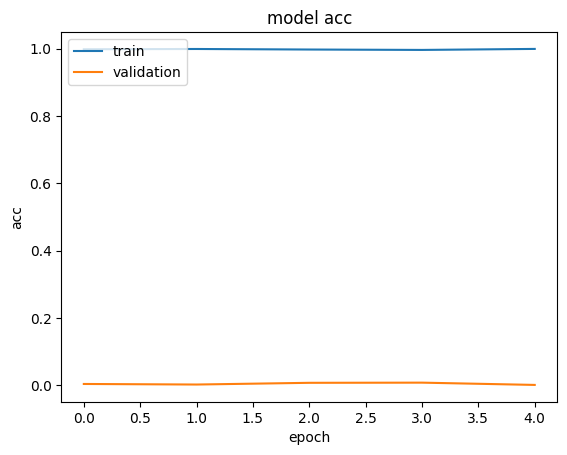

In [17]:
metric = 'acc'
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('model '+metric)
plt.ylabel(metric)
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [18]:
# Save the model in HDF5 format
# YOUR CODE HERE
model.save('vgg16_model.hdf5')

In [19]:
# Save the model in keras format
# YOUR CODE HERE
model.save('vgg16_model.keras')

#### ResNet50

In [20]:
# Build and compile a sequential model using ResNet50 as the base, with added Dense layers for classification, and display the model summary
# YOUR CODE HERE
model_resnet50 = Sequential()
model_resnet50.add(ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
model_resnet50.add(Flatten())
model_resnet50.add(Dense(50, activation='relu'))
model_resnet50.add(Dense(3, activation='softmax'))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [21]:
# Train the ResNet50-based model for 5 epochs using the training and validation data generators
# YOUR CODE HERE
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model_resnet50.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

In [22]:
# Plot the training and validation loss over epochs
# YOUR CODE HERE
callbacks = [ keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")]
history = model_resnet50.fit(train_generator,
          epochs=5,
          callbacks=callbacks,
          class_weight={0:1.0, 1:0.8, 2:1.2})


Epoch 1/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 174s 230ms/step - acc: 0.8574 - loss: 0.3942
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


503/503 ━━━━━━━━━━━━━━━━━━━━ 149s 178ms/step - acc: 0.9913 - loss: 0.0262
Epoch 3/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 89s 174ms/step - acc: 0.9977 - loss: 0.0086
Epoch 4/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 90s 178ms/step - acc: 0.9969 - loss: 0.0125
Epoch 5/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 142s 178ms/step - acc: 0.9954 - loss: 0.0139


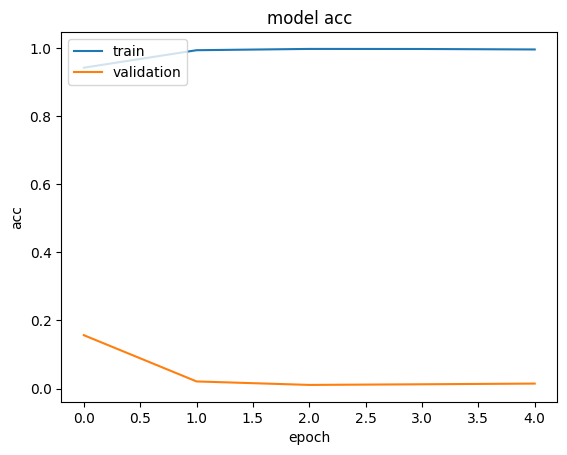

In [23]:
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('model '+metric)
plt.ylabel(metric)
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

### Capture the live image using the below code cell and predict

After executing above cell and capturing the photo, load the captured photo and predict with model.

**Note:**
* Convert the image to numpy array and resize to the shape which the model accepts.
* Extend the dimension (to 4-D shape) of an image, as the model is trained on a batch of inputs.

In [ ]:
class_distribution

### Report Analysis

- Compare the accuracies for the Pre-trained vs CNN models
- Which model detects the mask/no mask/ partial mask more accurately with the live pictures?
- What process was followed to tune the hyperparameters?
- Discuss the confusion matrix in terms of the misclassifications

### Kaggle predictions

In [27]:
# Download the saved VGG model
# Your code here
from google.colab import files
files.download('vgg16_model.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Instructions for preparing Kaggle competition predictions

Important: Refer the [Kaggle Team Creation Instructions Doc](https://drive.google.com/file/d/1V0GlyApGPvksSEPhlfkJIQndt4zIBOdY/view?usp=drive_link)

* Load the image paths from Kaggle testset using `glob`
* Read the Images using `PIL.Image.open` and resize to required shape.
* Get the predictions using trained model and prepare a csv file
  - FC layer of DeepNet model gives output for each class, consider the maximum value among all classes as prediction using `np.argmax`.
* Predictions (csv) file should contain 2 columns as Sample_Submission.csv
  - First column is the img_path which is considered as index
  - Second column is prediction in decoded form (for eg. with_mask, partial_mask, without_mask).
  - Note that at the time of submission to Kaggle, predictions need to be sorted in ascending order i.e, same as sample submission file.

<font color='magenta'>If you are unable to download the data and sample submission from the Kaggle Competition site then please use the download cell below.</font>


In [28]:
#@title Download test data and SampleSubmission file for Kaggle submission
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/FaceMask_Kaggle_test.zip
!unzip -qq FaceMask_Kaggle_test.zip
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/Sample_Submission.csv
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


#### Create a dataframe with kaggle data

In [29]:
for path in glob.glob("FaceMask_Kaggle_test/*"):
    print(path)

FaceMask_Kaggle_test/268.jpg
FaceMask_Kaggle_test/72.jpg
FaceMask_Kaggle_test/489.jpg
FaceMask_Kaggle_test/289.jpg
FaceMask_Kaggle_test/386.jpg
FaceMask_Kaggle_test/530.jpg
FaceMask_Kaggle_test/431.jpg
FaceMask_Kaggle_test/252.jpg
FaceMask_Kaggle_test/8.jpg
FaceMask_Kaggle_test/300.jpg
FaceMask_Kaggle_test/338.jpg
FaceMask_Kaggle_test/563.jpg
FaceMask_Kaggle_test/139.jpg
FaceMask_Kaggle_test/442.jpg
FaceMask_Kaggle_test/118.jpg
FaceMask_Kaggle_test/638.jpg
FaceMask_Kaggle_test/335.jpg
FaceMask_Kaggle_test/453.jpg
FaceMask_Kaggle_test/381.jpg
FaceMask_Kaggle_test/345.jpg
FaceMask_Kaggle_test/215.jpg
FaceMask_Kaggle_test/117.jpg
FaceMask_Kaggle_test/287.jpg
FaceMask_Kaggle_test/210.jpg
FaceMask_Kaggle_test/486.jpg
FaceMask_Kaggle_test/334.jpg
FaceMask_Kaggle_test/374.jpg
FaceMask_Kaggle_test/75.jpg
FaceMask_Kaggle_test/145.jpg
FaceMask_Kaggle_test/62.jpg
FaceMask_Kaggle_test/52.jpg
FaceMask_Kaggle_test/400.jpg
FaceMask_Kaggle_test/41.jpg
FaceMask_Kaggle_test/339.jpg
FaceMask_Kaggle_test/

In [30]:
# Create a DataFrame of image paths from the "FaceMask_Kaggle_test" directory, extract and sort by the numeric order in the filenames, and display the DataFrame
# YOUR CODE HERE
import pandas as pd
import os
import re

def create_image_path_dataframe(directory="FaceMask_Kaggle_test"):
    """
    Creates a DataFrame of image paths from a directory, sorted by numeric order in filenames.

    Args:
        directory (str): Path to the directory containing images.

    Returns:
        pandas.DataFrame: DataFrame with 'image_path' and 'image_number' columns.
    """

    image_paths = []
    for path in glob.glob("FaceMask_Kaggle_test/*"):
        image_paths.append(path)

    # Extract numeric part of filenames and sort
    df = pd.DataFrame({'image_path': image_paths})
    df['image_number'] = df['image_path'].str.extract(r'(\d+)').astype(int)  # Assumes numeric part in filename
    df = df.sort_values(by=['image_number']).reset_index(drop=True)

    return df

# Create and display the DataFrame
image_df = create_image_path_dataframe()
print(image_df)

                       image_path  image_number
0      FaceMask_Kaggle_test/1.jpg             1
1      FaceMask_Kaggle_test/2.jpg             2
2      FaceMask_Kaggle_test/3.jpg             3
3      FaceMask_Kaggle_test/4.jpg             4
4      FaceMask_Kaggle_test/5.jpg             5
..                            ...           ...
655  FaceMask_Kaggle_test/656.jpg           656
656  FaceMask_Kaggle_test/657.jpg           657
657  FaceMask_Kaggle_test/658.jpg           658
658  FaceMask_Kaggle_test/659.jpg           659
659  FaceMask_Kaggle_test/660.jpg           660

[660 rows x 2 columns]


In [31]:
# Display rows 120 to 135 of the DataFrame
# YOUR CODE HERE
print(image_df.iloc[120:136])

                       image_path  image_number
120  FaceMask_Kaggle_test/121.jpg           121
121  FaceMask_Kaggle_test/122.jpg           122
122  FaceMask_Kaggle_test/123.jpg           123
123  FaceMask_Kaggle_test/124.jpg           124
124  FaceMask_Kaggle_test/125.jpg           125
125  FaceMask_Kaggle_test/126.jpg           126
126  FaceMask_Kaggle_test/127.jpg           127
127  FaceMask_Kaggle_test/128.jpg           128
128  FaceMask_Kaggle_test/129.jpg           129
129  FaceMask_Kaggle_test/130jpeg           130
130  FaceMask_Kaggle_test/131.jpg           131
131  FaceMask_Kaggle_test/132.jpg           132
132  FaceMask_Kaggle_test/133.jpg           133
133  FaceMask_Kaggle_test/134.jpg           134
134  FaceMask_Kaggle_test/135.jpg           135
135  FaceMask_Kaggle_test/136jpeg           136


#### Extract features of kaggle data

In [32]:
# Resize images from the img_path column in the DataFrame df to 224x224, append them to a list, and convert the list to a NumPy array
# YOUR CODE HERE
import numpy as np
from PIL import Image

def preprocess_images_from_dataframe(df, target_size=(224, 224)):
    """
    Resizes images from the 'img_path' column of a DataFrame,
    appends them to a list, and converts the list to a NumPy array.

    Args:
        df (pandas.DataFrame): DataFrame containing 'img_path' column.
        target_size (tuple): Desired size of the images (width, height).

    Returns:
        numpy.ndarray: NumPy array of resized images.
    """

    resized_images = []
    for image_path in df['image_path']:
        img = Image.open(image_path)

        # Convert to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')

        img = img.resize(target_size)
        img_array = np.array(img)
        resized_images.append(img_array)

    return np.array(resized_images)

# Example usage:
resized_images_array = preprocess_images_from_dataframe(image_df)

print(resized_images_array.shape)  # Print the shape of the NumPy array

(660, 224, 224, 3)


#### Load the saved model and predict the kaggle features

In [39]:
# Ensure consistent usage of TensorFlow's Keras
# YOUR CODE HERE
# predictions = model_vgg.predict(resized_images_array)
predictions = model_resnet50.predict(resized_images_array)

#class_names = ['partial_mask','with_mask','without_mask']
# predicted_classes = [class_names[np.argmax(prediction)] for prediction in predictions]

# # Print or store the predictions as needed
# for i, predicted_class in enumerate(predicted_classes):
#     print(f"Image {i}: Predicted class - {predicted_class}")

# # You can also add the predictions to your DataFrame:
# image_df['predicted_class'] = predicted_classes
# print(image_df)

21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step


In [34]:
# Generate predictions
# YOUR CODE HERE
predictions = model_vgg.predict(resized_images_array)

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step


In [40]:
# Convert the model predictions to class labels using argmax and display the unique predicted classes.
# YOUR CODE HERE
predicted_classes = [class_names[np.argmax(prediction)] for prediction in predictions]


#### Prepare the kaggle predictions CSV file after decoding the integer predictions

In [41]:
# Create a DataFrame with image paths and predicted labels, replacing numeric labels with corresponding mask status categories.
# YOUR CODE HERE
image_df['predicted_class'] = predicted_classes

In [43]:
# Save the kaggle DataFrame to a CSV file named "kaggle_submission_w2.csv" without including the index.
# YOUR CODE HERE
results_df = pd.DataFrame({'img_path': image_df['image_path'], 'label': predicted_classes})
results_df.to_csv('kaggle_submission_facemask.csv', index=False)